# Notebook 02 — Composants wav2vec 2.0

## Architecture wav2vec 2.0 : 3 blocs principaux

wav2vec 2.0 (Baevski et al., 2020) est une architecture d'apprentissage auto-supervisé pour la parole.

```
Audio brut (16kHz)  →  Feature Encoder (CNN 1D)  →  Représentations latentes z
                              ↓                              ↓
                    Quantization Module          Context Network (Transformer)
                    (Gumbel-Softmax)             (self-attention du chapitre 1)
                              ↓                              ↓
                    Pseudo-tokens q              Représentations contextuelles c
                              └──── Perte Contrastive L_m ────┘
```

**Rappel chapitre 1** : Le Context Network réutilise le self-attention (Scaled Dot-Product + Multi-Head).

Ce notebook implémente les 3 composants clés :
1. **Feature Encoder** — CNN 1D, réduction temporelle ~320×
2. **Quantization Module** — Codebook + Gumbel-Softmax
3. **Perte Contrastive** — Distinguer la cible parmi les distracteurs

In [1]:
import sys
from pathlib import Path

src_path = str(Path("../../src").resolve())
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['figure.dpi'] = 100

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

PyTorch version: 2.10.0+cu128
CUDA disponible: False


---
## Cell 2 — IMPLÉMENTATION FROM SCRATCH : Conv1D manuelle

Avant d'utiliser PyTorch, comprenons la convolution 1D avec une boucle explicite.

**Principe du stride** : Le stride contrôle la réduction temporelle.
Avec stride=2, la sortie a 2× moins de pas temporels que l'entrée.

Signal d'entrée : shape=(1, 20)
Kernel : shape=(4, 1, 5)

Stride=1 : output shape=(4, 16)
  Longueur attendue : (20 - 5) // 1 + 1 = 16

Stride=2 : output shape=(4, 8)
  Longueur attendue : (20 - 5) // 2 + 1 = 8

Stride=5, kernel=10 : output shape=(4, 3)
  Longueur attendue : (20 - 10) // 5 + 1 = 3


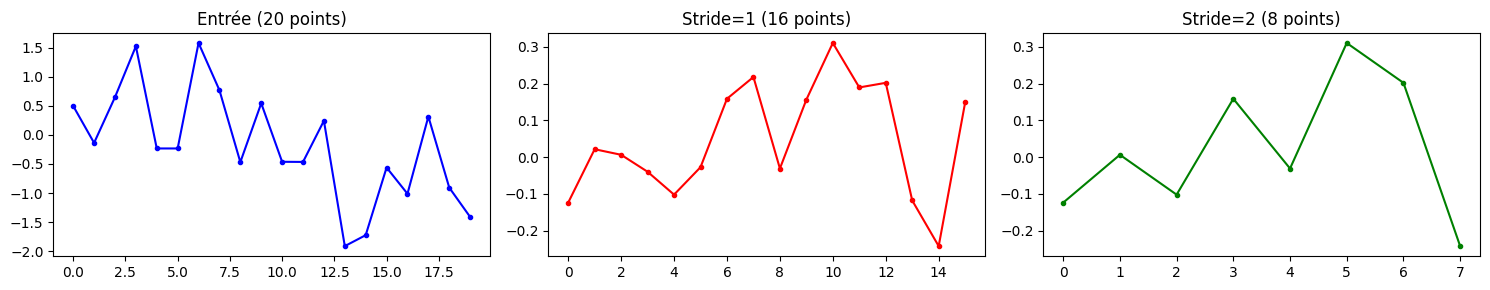

In [5]:
from audio.feature_encoder import conv1d_from_scratch
from IPython.display import display, Markdown, Audio

# Créer un signal simple : 1 canal, 20 échantillons
np.random.seed(42)
signal = np.random.randn(1, 20)  # (channels_in=1, length=20)
print(f"Signal d'entrée : shape={signal.shape}")




# Noyau de convolution : 4 filtres, 1 canal d'entrée, taille 5
kernel = np.random.randn(4, 1, 5) * 0.1  # (channels_out=4, channels_in=1, kernel_size=5)
print(f"Kernel : shape={kernel.shape}")

# --- Stride = 1 (pas de réduction) ---
out_s1 = conv1d_from_scratch(signal, kernel, stride=1)
print(f"\nStride=1 : output shape={out_s1.shape}")
print(f"  Longueur attendue : (20 - 5) // 1 + 1 = {(20 - 5) // 1 + 1}")

# --- Stride = 2 (réduction 2×) ---
out_s2 = conv1d_from_scratch(signal, kernel, stride=2)
print(f"\nStride=2 : output shape={out_s2.shape}")
print(f"  Longueur attendue : (20 - 5) // 2 + 1 = {(20 - 5) // 2 + 1}")

# --- Stride = 5 (réduction 5×, comme la couche 1 de wav2vec 2.0) ---
kernel_big = np.random.randn(4, 1, 10) * 0.1  # kernel_size=10
out_s5 = conv1d_from_scratch(signal, kernel_big, stride=5)
print(f"\nStride=5, kernel=10 : output shape={out_s5.shape}")
print(f"  Longueur attendue : (20 - 10) // 5 + 1 = {(20 - 10) // 5 + 1}")

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].plot(signal[0], 'b-o', markersize=3)
axes[0].set_title(f'Entrée ({signal.shape[1]} points)')
axes[1].plot(out_s1[0], 'r-o', markersize=3)
axes[1].set_title(f'Stride=1 ({out_s1.shape[1]} points)')
axes[2].plot(out_s2[0], 'g-o', markersize=3)
axes[2].set_title(f'Stride=2 ({out_s2.shape[1]} points)')
plt.tight_layout()
plt.show()

In [ ]:
#1. Charger un dataset audio de votre choix depuis huggingface
#2. Isoler 1 audio et le faire passer dans une couche de convolution 1D avec stride=5
#3. Visualiser le signal d'entrée et la sortie de la convolution pour comprendre l'effet du stride

In [4]:
Audio(signal, rate=16000)

---
## Cell 3 — IMPLÉMENTATION PYTORCH : FeatureEncoder complet

Le FeatureEncoder de wav2vec 2.0 utilise 7 couches Conv1D avec des strides progressifs.
Le stride total est 5 × 2⁶ = 320, réduisant 16 000 échantillons/s à ~50 vecteurs/s.

In [6]:
from audio.feature_encoder import FeatureEncoder

# Créer le Feature Encoder
encoder = FeatureEncoder(d_model=512)
print(f"Stride total : {encoder.total_stride}")
print(f"Nombre de paramètres : {sum(p.numel() for p in encoder.parameters()):,}")

# Simuler 1 seconde d'audio à 16kHz
batch_size = 2
num_samples = 16000  # 1 seconde
waveform = torch.randn(batch_size, 1, num_samples)
print(f"\nEntrée : {waveform.shape} (batch={batch_size}, channels=1, samples={num_samples})")

# Forward pass avec shape checks à chaque couche
x = waveform
for i, layer in enumerate(encoder.layers):
    x = layer(x)
    k, s = encoder.LAYER_CONFIGS[i]
    print(f"  Couche {i+1} (kernel={k}, stride={s}) → {x.shape}")

# Forward pass complet (avec LayerNorm)
output = encoder(waveform)
print(f"\nSortie finale : {output.shape}")
print(f"Réduction temporelle : {num_samples} → {output.shape[2]} ({num_samples / output.shape[2]:.0f}×)")
print(f"Longueur calculée : {encoder.compute_output_length(num_samples)}")

Stride total : 320
Nombre de paramètres : 4,200,448

Entrée : torch.Size([2, 1, 16000]) (batch=2, channels=1, samples=16000)
  Couche 1 (kernel=10, stride=5) → torch.Size([2, 512, 3199])
  Couche 2 (kernel=3, stride=2) → torch.Size([2, 512, 1599])
  Couche 3 (kernel=3, stride=2) → torch.Size([2, 512, 799])
  Couche 4 (kernel=3, stride=2) → torch.Size([2, 512, 399])
  Couche 5 (kernel=3, stride=2) → torch.Size([2, 512, 199])
  Couche 6 (kernel=2, stride=2) → torch.Size([2, 512, 99])
  Couche 7 (kernel=2, stride=2) → torch.Size([2, 512, 49])

Sortie finale : torch.Size([2, 512, 49])
Réduction temporelle : 16000 → 49 (327×)
Longueur calculée : 49


---
## Cell 4 — Comparaison from-scratch vs PyTorch

Vérifions que les deux implémentations produisent des shapes cohérentes.

In [7]:
from audio.feature_encoder import feature_encoder_from_scratch

# Petit signal pour la version from-scratch (plus lent)
np.random.seed(42)
small_waveform = np.random.randn(3200).astype(np.float32)  # 0.2 seconde

print("=" * 60)
print("FROM SCRATCH (NumPy)")
print("=" * 60)
output_scratch = feature_encoder_from_scratch(small_waveform)

print(f"\n{'=' * 60}")
print("PYTORCH")
print("=" * 60)
waveform_pt = torch.tensor(small_waveform).unsqueeze(0).unsqueeze(0)  # (1, 1, 3200)
with torch.no_grad():
    output_pt = encoder(waveform_pt)
print(f"  Output shape: {output_pt.shape}")

print(f"\nComparaison des shapes :")
print(f"  From scratch : {output_scratch.shape} (d_model, T)")
print(f"  PyTorch      : {output_pt.shape} (batch, d_model, T)")
print(f"  T from scratch = {output_scratch.shape[1]}, T PyTorch = {output_pt.shape[2]}")

FROM SCRATCH (NumPy)
  [Feature Encoder] Input shape: (1, 3200)
  [Feature Encoder] Couche 1: shape=(512, 639), stride=5
  [Feature Encoder] Couche 2: shape=(512, 319), stride=2
  [Feature Encoder] Couche 3: shape=(512, 159), stride=2
  [Feature Encoder] Couche 4: shape=(512, 79), stride=2
  [Feature Encoder] Couche 5: shape=(512, 39), stride=2
  [Feature Encoder] Couche 6: shape=(512, 19), stride=2
  [Feature Encoder] Couche 7: shape=(512, 9), stride=2
  [Feature Encoder] Output shape: (512, 9)

PYTORCH
  Output shape: torch.Size([1, 512, 9])

Comparaison des shapes :
  From scratch : (512, 9) (d_model, T)
  PyTorch      : torch.Size([1, 512, 9]) (batch, d_model, T)
  T from scratch = 9, T PyTorch = 9


---
## Cell 5 — IMPLÉMENTATION FROM SCRATCH : Quantification par argmin

La quantification vectorielle remplace chaque vecteur latent par l'entrée
la plus proche dans un codebook (livre de codes). C'est l'équivalent audio
du lookup dans un vocabulaire de tokens.

Vecteurs d'entrée : shape=(10, 8)
Codebook : shape=(16, 8) (16 entrées de dimension 8)

Vecteurs quantifiés : shape=(10, 8)
Indices sélectionnés : [15 13  8  6 13 13 11  1  4  1]

✓ Chaque vecteur quantifié correspond à une entrée du codebook


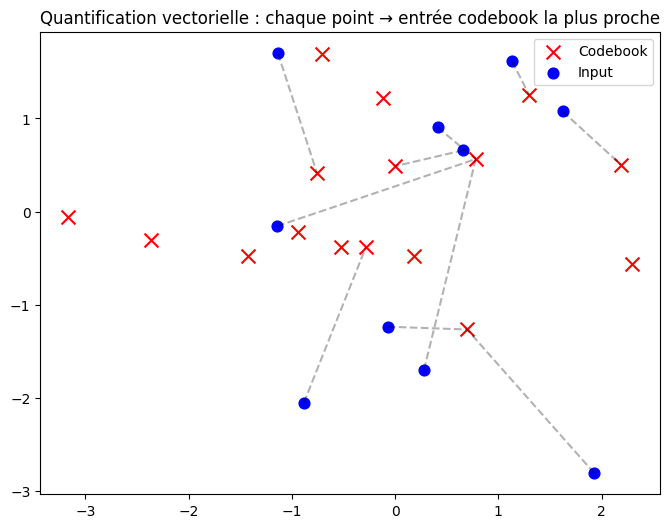

In [8]:
from audio.quantization import quantize_from_scratch

# Créer des vecteurs latents simulés et un codebook
np.random.seed(42)
T, d = 10, 8  # 10 pas temporels, dimension 8
V = 16  # 16 entrées dans le codebook

x = np.random.randn(T, d).astype(np.float32)
codebook = np.random.randn(V, d).astype(np.float32)

print(f"Vecteurs d'entrée : shape={x.shape}")
print(f"Codebook : shape={codebook.shape} ({V} entrées de dimension {d})")

# Quantification
quantized, indices = quantize_from_scratch(x, codebook)
print(f"\nVecteurs quantifiés : shape={quantized.shape}")
print(f"Indices sélectionnés : {indices}")

# Vérifier que chaque vecteur quantifié est bien une entrée du codebook
for t in range(T):
    assert np.allclose(quantized[t], codebook[indices[t]]), f"Mismatch at t={t}"
print("\n✓ Chaque vecteur quantifié correspond à une entrée du codebook")

# Visualisation des clusters
from sklearn.decomposition import PCA
try:
    pca = PCA(n_components=2)
    all_points = np.vstack([x, codebook])
    projected = pca.fit_transform(all_points)
    x_proj = projected[:T]
    cb_proj = projected[T:]

    plt.figure(figsize=(8, 6))
    plt.scatter(cb_proj[:, 0], cb_proj[:, 1], c='red', marker='x', s=100, label='Codebook')
    plt.scatter(x_proj[:, 0], x_proj[:, 1], c='blue', marker='o', s=60, label='Input')
    for t in range(T):
        plt.plot([x_proj[t, 0], cb_proj[indices[t], 0]],
                 [x_proj[t, 1], cb_proj[indices[t], 1]], 'k--', alpha=0.3)
    plt.legend()
    plt.title('Quantification vectorielle : chaque point → entrée codebook la plus proche')
    plt.show()
except ImportError:
    print("sklearn non disponible, visualisation PCA ignorée")

---
## Cell 6 — IMPLÉMENTATION PYTORCH : GumbelVectorQuantizer

Le problème de l'argmin : il n'est **pas différentiable** (pas de gradient).

Solution : **Gumbel-Softmax** — une approximation différentiable de la sélection discrète.
- En forward : sélection hard (one-hot)
- En backward : gradient doux (softmax)

In [ ]:
from audio.quantization import GumbelVectorQuantizer

# Créer le quantizer
input_dim = 512
num_groups = 2
num_vars = 320
quantizer = GumbelVectorQuantizer(
    input_dim=input_dim, num_groups=num_groups, num_vars=num_vars
)
print(f"Configuration :")
print(f"  input_dim={input_dim}, num_groups={num_groups}, num_vars={num_vars}")
print(f"  dim_per_group={quantizer.dim_per_group}")
print(f"  Nombre de paramètres : {sum(p.numel() for p in quantizer.parameters()):,}")

# Simuler des vecteurs latents
batch, T = 2, 50
z = torch.randn(batch, T, input_dim)
print(f"\nEntrée : {z.shape}")

# Quantification (mode entraînement)
quantizer.train()
q_train, perplexity = quantizer(z)
print(f"Sortie (train) : {q_train.shape}")
print(f"Perplexité : shape={perplexity.shape}, mean={perplexity.mean():.4f}")
print(f"Température courante : {quantizer.current_temp:.4f}")

# Quantification (mode inférence)
quantizer.eval()
with torch.no_grad():
    q_eval, perp_eval = quantizer(z)
print(f"\nSortie (eval) : {q_eval.shape}")
print(f"Shape préservée ? {q_train.shape == z.shape}")

---
## Cell 7 — IMPLÉMENTATION FROM SCRATCH : Perte contrastive

La perte contrastive force le modèle à distinguer la cible quantifiée correcte
parmi des distracteurs négatifs.

$$L_m = -\log \frac{\exp(\text{sim}(c_t, q_t) / \kappa)}{\exp(\text{sim}(c_t, q_t) / \kappa) + \sum_{\tilde{q}} \exp(\text{sim}(c_t, \tilde{q}) / \kappa)}$$

In [ ]:
from audio.contrastive_loss import (
    cosine_similarity_from_scratch,
    contrastive_loss_from_scratch,
)

np.random.seed(42)
d = 8

# Vecteur contexte et cible positive
context = np.random.randn(d)
target = context + np.random.randn(d) * 0.1  # Proche du contexte

# Distracteurs négatifs (éloignés)
num_negatives = 5
negatives = np.random.randn(num_negatives, d)

# Similarité cosinus
sim_pos = cosine_similarity_from_scratch(context, target)
print(f"Similarité (contexte, cible positive) : {sim_pos:.4f}")
for i in range(num_negatives):
    sim_neg = cosine_similarity_from_scratch(context, negatives[i])
    print(f"Similarité (contexte, négatif {i}) : {sim_neg:.4f}")

# Perte contrastive
loss = contrastive_loss_from_scratch(context, target, negatives, temperature=0.1)
print(f"\nPerte contrastive L_m = {loss:.4f}")
print(f"  (Plus la cible est similaire au contexte, plus la perte est faible)")

# Démonstration : perte avec cible identique au contexte
loss_perfect = contrastive_loss_from_scratch(context, context, negatives, temperature=0.1)
print(f"\nPerte avec cible = contexte : {loss_perfect:.4f} (devrait être très faible)")

# Perte avec cible aléatoire
loss_random = contrastive_loss_from_scratch(context, np.random.randn(d), negatives, temperature=0.1)
print(f"Perte avec cible aléatoire : {loss_random:.4f} (devrait être plus élevée)")

---
## Cell 8 — IMPLÉMENTATION PYTORCH : Perte contrastive vectorisée + diversité

Version vectorisée pour l'entraînement efficace, plus la perte de diversité
$L_d$ qui empêche le mode collapse du codebook.

In [ ]:
from audio.contrastive_loss import (
    contrastive_loss,
    sample_negatives,
    diversity_loss,
)

torch.manual_seed(42)
batch, T, d = 2, 20, 64
num_neg = 10

# Simuler des vecteurs contexte et quantifiés
context_vecs = torch.randn(batch, T, d)
quantized_vecs = context_vecs + torch.randn(batch, T, d) * 0.3  # Proches

# Échantillonner des négatifs
negs = sample_negatives(quantized_vecs, num_negatives=num_neg)
print(f"Context : {context_vecs.shape}")
print(f"Quantized : {quantized_vecs.shape}")
print(f"Negatives : {negs.shape}")

# Perte contrastive
L_m = contrastive_loss(context_vecs, quantized_vecs, negs, temperature=0.1)
print(f"\nPerte contrastive L_m = {L_m.item():.4f}")

# Perte de diversité
# Simuler des probabilités d'utilisation du codebook
G, V = 2, 320
# Cas 1 : utilisation uniforme (bonne)
uniform_probs = torch.ones(G, V) / V
L_d_uniform = diversity_loss(uniform_probs, num_groups=G, num_vars=V)
print(f"\nL_d (utilisation uniforme) = {L_d_uniform.item():.4f} (devrait être ~0)")

# Cas 2 : mode collapse (mauvais)
collapse_probs = torch.zeros(G, V)
collapse_probs[:, 0] = 1.0  # Toujours la même entrée
L_d_collapse = diversity_loss(collapse_probs, num_groups=G, num_vars=V)
print(f"L_d (mode collapse) = {L_d_collapse.item():.4f} (devrait être ~1)")

# Perte totale
alpha = 0.1
L_total = L_m + alpha * L_d_uniform
print(f"\nPerte totale L = L_m + {alpha} × L_d = {L_total.item():.4f}")

---
## Cell 9 — Pipeline complet PyTorch : audio → encoder → quantize → mask → loss

Assemblons tous les composants pour simuler un pas d'entraînement wav2vec 2.0.

In [ ]:
from audio.feature_encoder import FeatureEncoder
from audio.quantization import GumbelVectorQuantizer
from audio.contrastive_loss import contrastive_loss, sample_negatives, diversity_loss

torch.manual_seed(42)

# --- Configuration ---
d_model = 512
num_groups = 2
num_vars = 320
mask_prob = 0.065  # Probabilité de masquage
mask_length = 10   # Longueur des spans masqués
num_negatives = 100
alpha = 0.1  # Poids de la perte de diversité

# --- Modèle ---
encoder = FeatureEncoder(d_model=d_model)
quantizer = GumbelVectorQuantizer(input_dim=d_model, num_groups=num_groups, num_vars=num_vars)

# --- Données ---
batch_size = 2
waveform = torch.randn(batch_size, 1, 16000)  # 1 seconde
print(f"1. Audio brut : {waveform.shape}")

# --- Étape 1 : Feature Encoder ---
z = encoder(waveform)  # (batch, d_model, T)
print(f"2. Feature Encoder → z : {z.shape}")

# Transposer pour le quantizer : (batch, T, d_model)
z = z.transpose(1, 2)
T = z.shape[1]

# --- Étape 2 : Quantification ---
q, perplexity = quantizer(z)  # (batch, T, d_model)
print(f"3. Quantification → q : {q.shape}")

# --- Étape 3 : Masquage ---
# Créer un masque aléatoire (simplification du masquage par spans)
mask = torch.rand(batch_size, T) < mask_prob
num_masked = mask.sum().item()
print(f"4. Masquage : {num_masked} positions masquées sur {batch_size * T}")

# Simuler le Context Network (ici on utilise z directement comme contexte)
# Dans le vrai wav2vec 2.0, z passe par un Transformer
c = z  # Simplification : contexte = latent

# --- Étape 4 : Échantillonner les négatifs ---
negs = sample_negatives(q, num_negatives=min(num_negatives, T - 1))
print(f"5. Négatifs échantillonnés : {negs.shape}")

# --- Étape 5 : Perte contrastive ---
L_m = contrastive_loss(c, q, negs, temperature=0.1)
L_d = diversity_loss(perplexity, num_groups=num_groups, num_vars=num_vars)
L = L_m + alpha * L_d

print(f"\n--- Pertes ---")
print(f"  L_m (contrastive) = {L_m.item():.4f}")
print(f"  L_d (diversité)   = {L_d.item():.4f}")
print(f"  L (totale)        = {L.item():.4f}")

# --- Backward pass (vérifier que les gradients passent) ---
L.backward()
print(f"\n✓ Backward pass réussi !")
print(f"  Gradient encoder couche 1 : {encoder.layers[0][0].weight.grad is not None}")
print(f"  Gradient codebook : {quantizer.codebook.grad is not None}")

---
## Cell 10 — Visualisation des représentations latentes

Visualisons les représentations à différentes étapes du pipeline.

In [ ]:
# Recalculer sans gradients pour la visualisation
encoder.eval()
quantizer.eval()

with torch.no_grad():
    waveform_viz = torch.randn(1, 1, 16000)
    z_viz = encoder(waveform_viz).transpose(1, 2)  # (1, T, d_model)
    q_viz, _ = quantizer(z_viz)

z_np = z_viz[0].numpy()  # (T, d_model)
q_np = q_viz[0].numpy()  # (T, d_model)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. Waveform
axes[0, 0].plot(waveform_viz[0, 0].numpy(), linewidth=0.5)
axes[0, 0].set_title(f'Waveform ({waveform_viz.shape[2]} échantillons)')
axes[0, 0].set_xlabel('Échantillon')

# 2. Représentations latentes z (heatmap)
im1 = axes[0, 1].imshow(z_np.T[:64], aspect='auto', cmap='viridis')
axes[0, 1].set_title(f'Latent z ({z_np.shape[0]} frames × {z_np.shape[1]} dims)')
axes[0, 1].set_xlabel('Frame')
axes[0, 1].set_ylabel('Dimension')
plt.colorbar(im1, ax=axes[0, 1])

# 3. Représentations quantifiées q (heatmap)
im2 = axes[1, 0].imshow(q_np.T[:64], aspect='auto', cmap='viridis')
axes[1, 0].set_title(f'Quantized q ({q_np.shape[0]} frames × {q_np.shape[1]} dims)')
axes[1, 0].set_xlabel('Frame')
axes[1, 0].set_ylabel('Dimension')
plt.colorbar(im2, ax=axes[1, 0])

# 4. Différence z - q
diff = np.abs(z_np - q_np)
im3 = axes[1, 1].imshow(diff.T[:64], aspect='auto', cmap='hot')
axes[1, 1].set_title('|z - q| (erreur de quantification)')
axes[1, 1].set_xlabel('Frame')
axes[1, 1].set_ylabel('Dimension')
plt.colorbar(im3, ax=axes[1, 1])

plt.suptitle('Pipeline wav2vec 2.0 : Waveform → Latent z → Quantized q', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Erreur de quantification moyenne : {diff.mean():.4f}")
print(f"Réduction temporelle : {waveform_viz.shape[2]} → {z_np.shape[0]} ({waveform_viz.shape[2] / z_np.shape[0]:.0f}×)")